# Exploratory analyses of PBMCs at time point 1
----


---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
import sys
import cv2 as cv
import umap
import umap.plot
from statannot import add_stat_annotation

sys.path.append("../..")
from src.utils.io import get_file_list

seed = 1234
np.random.seed(seed)
random.seed(seed)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_in_dataset(
    data_dir, feature_file_path, qc_result_file_path, crop_images_path, n_crop_images=9
):
    all_features = []
    nuclei_dict = {}
    subdirs = [f.path for f in os.scandir(data_dir) if f.is_dir()]
    for subdir in tqdm(subdirs, desc="Load data"):
        feature_path = subdir + feature_file_path
        features = pd.read_csv(feature_path, index_col=0)
        features["sample"] = os.path.split(subdir)[1].split("_")[0].lower()
        qc_result_path = subdir + qc_result_file_path
        qc_results = pd.read_csv(qc_result_path, index_col=0)
        features.loc[qc_results.index, "qc_pass"] = qc_results.loc[
            qc_results.index, "qc_pass"
        ]
        all_features.append(features)
        crops_path = subdir + crop_images_path
        nuclei_dict[features["sample"][0]] = get_sample_crops(
            data_dir=crops_path, n_images=n_crop_images
        )
    all_features_df = all_features[0].copy()
    for i in range(1, len(all_features)):
        all_features_df = all_features_df.append(all_features[i])
    return nuclei_dict, all_features_df

<IPython.core.display.Javascript object>

In [3]:
def get_sample_crops(data_dir, n_images=9):
    crop_locs = get_file_list(data_dir)
    selected_crop_locs = np.random.choice(crop_locs, size=n_images, replace=False)
    images = []
    for loc in selected_crop_locs:
        images.append(tifffile.imread(loc))
    return images

<IPython.core.display.Javascript object>

In [4]:
def plot_multi_channel_image_grid(name, images, channel=0, cmap="viridis"):
    nrow = int(np.sqrt(len(images)))
    ncol = int(len(images) / nrow)
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[6, 6])
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].imshow(
            cv.resize(images[i][channel, :, :], dsize=(64, 64)),
            cmap=cmap,
            vmin=0,
            vmax=2 ** 16,
        )
        ax[i].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle("Sample: {}, channel: {}".format(name.upper(), channel))
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

In [5]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.head(20)
    # Define size of bar plot
    plt.figure(figsize=(8, 6))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title, pos_label=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 8))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            pos_label=pos_label,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

<IPython.core.display.Javascript object>

---

## 1. Read in data

First we will read in the data for the different healthy samples. To this end, we will automatically iterate over all subdirectories in a given root data directory. Each subdirectory is expected to include the data corresponding to one of the healthy individuals. If preprocessed using the previously described preprocessing pipeline each of those sub-directories includes the nuclear features corresponding to the respective sub-data set.

In [7]:
hv_root_data_dir = "../../data/pbmc_hv/proteins/"
hv_feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
hv_crop_images_path = "/preprocessed/full_pipeline/segmentation/nuclear_crops_2d"
hv_qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [8]:
hv_sample_images, hv_features = read_in_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=hv_feature_file_path,
    qc_result_file_path=hv_qc_result_file_path,
    crop_images_path=hv_crop_images_path,
    n_crop_images=9,
)
hv_features.loc[:, "condition"] = "healthy"

Load data: 100%|██████████| 10/10 [00:00<00:00, 30.41it/s]


<IPython.core.display.Javascript object>

In [11]:
pt_root_data_dir = "../../data/pbmc_pt/proteins/timepoint_1/"
pt_feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
pt_crop_images_path = "/preprocessed/full_pipeline/segmentation/nuclear_crops_2d"
pt_qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [13]:
pt_sample_images, pt_features = read_in_dataset(
    data_dir=pt_root_data_dir,
    feature_file_path=pt_feature_file_path,
    qc_result_file_path=pt_qc_result_file_path,
    crop_images_path=pt_crop_images_path,
    n_crop_images=9,
)
pt_features.loc[:, "condition"] = "cancer"

Load data: 100%|██████████| 4/4 [00:00<00:00, 27.07it/s]


<IPython.core.display.Javascript object>

In [14]:
nuclear_features = hv_features.append(pt_features)
nuclear_features

label  min_calliper  \
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_0         1          54.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_1         2          60.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_2         3          59.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_3         4          52.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_4         5          56.0   
...                                                   ...           ...   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...      3          60.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...      4          60.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...      5          64.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...      6          60.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...      7          66.0   

                                                    max_calliper  \
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_0             99.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_1             74.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_2             68.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_3             72.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_4             67.0   
...                                                          ...   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...          80.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...          86.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...          80.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...          86.0   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...          80.0   

                                                    smallest_largest_calliper  \
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_0                      0.545455   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_1                      0.810811   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_2                      0.867647   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_3                      0.722222   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_4                      0.835821   
...                                                                       ...   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...                   0.750000   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...                   0.697674   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...                   0.800000   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...                   0.697674   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...                   0.825000   

                                                    min_radius  max_radius  \
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_0      23.626240   49.722393   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_1      26.453451   37.312476   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_2      27.866305   34.020870   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_3      23.077498   35.956590   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_4      23.439901   33.648402   
...                                                        ...         ...   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...   25.198610   41.453576   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...   16.463477   44.038486   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...   29.369935   40.584952   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...   24.931237   45.937173   
P16_1_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_...   20.331442   39.674759   

                                                    med_radius  avg_radius  \
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_0      36.296884   36.731151   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_1      32.733461   32.635644   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_2      30.952123   30.945130   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_1_3      31.364548   30.548651   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21

<IPython.core.display.Javascript object>

---

## 2. Overview of the data

After reading in the data, we will provide a first overview of the data, by plotting 9 randomly sampled, max-z projected nuclei for each biological sample in all three channels.

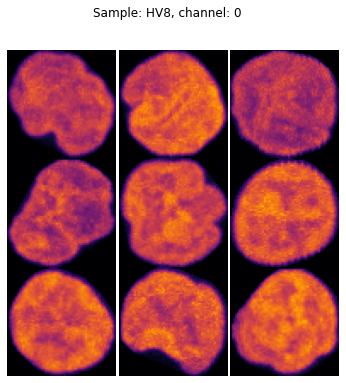

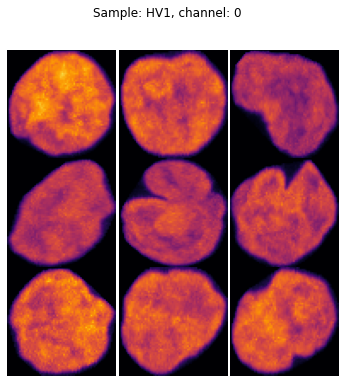

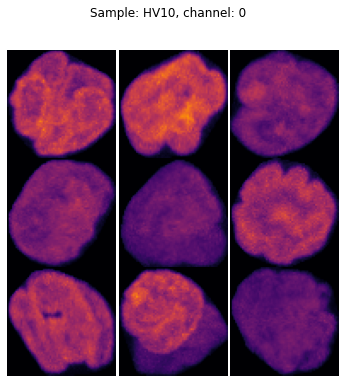

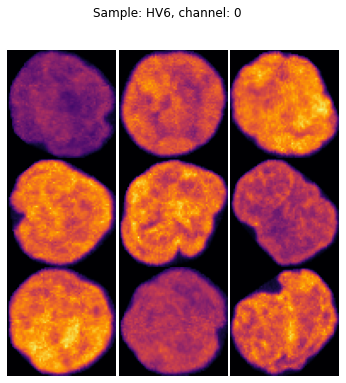

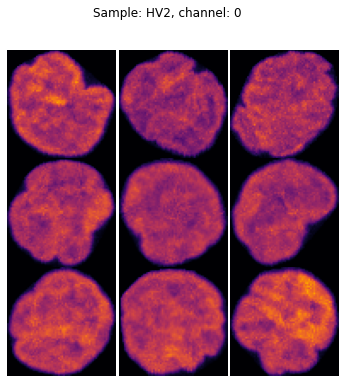

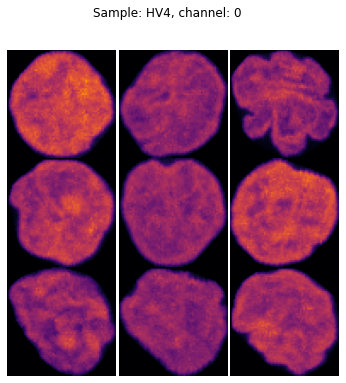

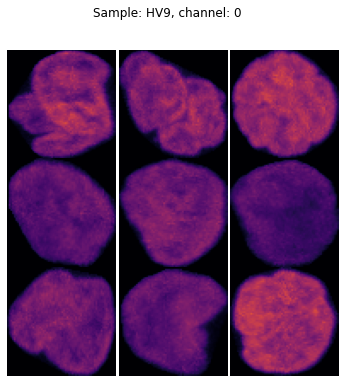

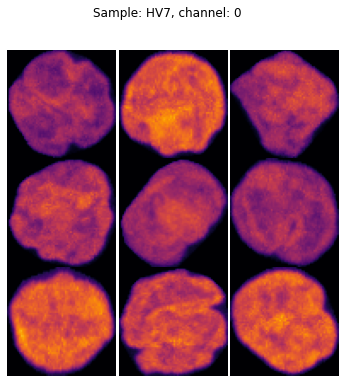

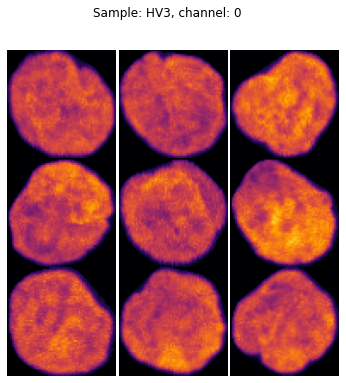

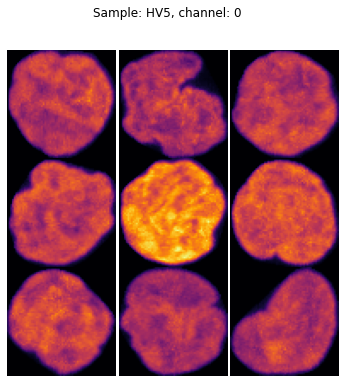

<IPython.core.display.Javascript object>

In [15]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=0, cmap="inferno")

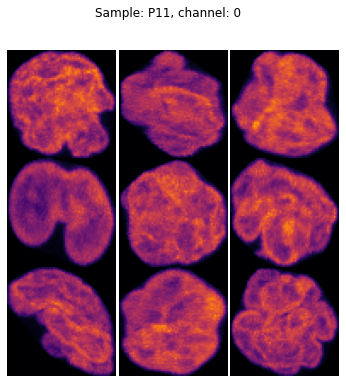

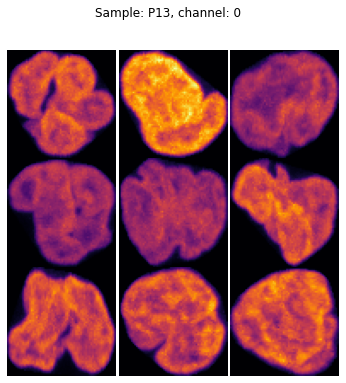

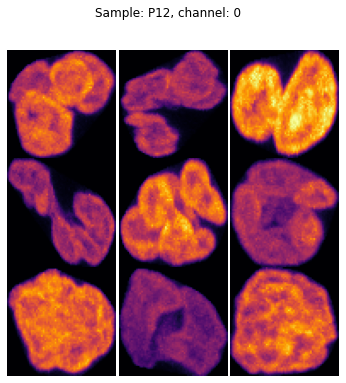

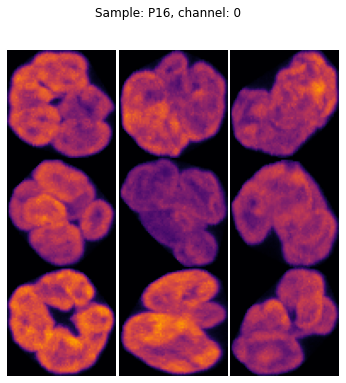

<IPython.core.display.Javascript object>

In [16]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=0, cmap="inferno")

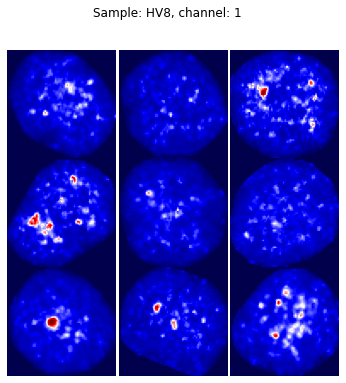

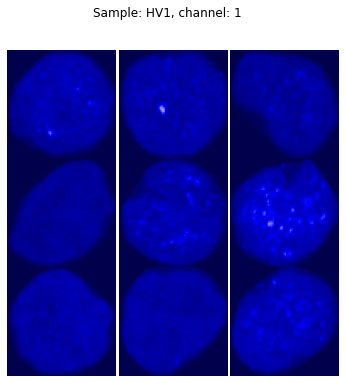

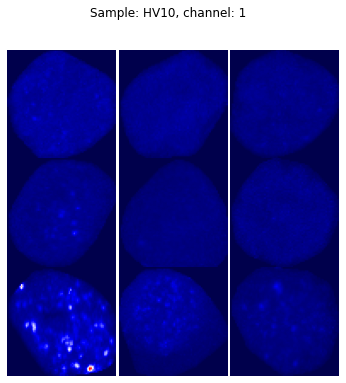

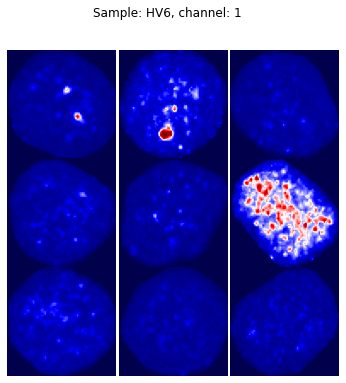

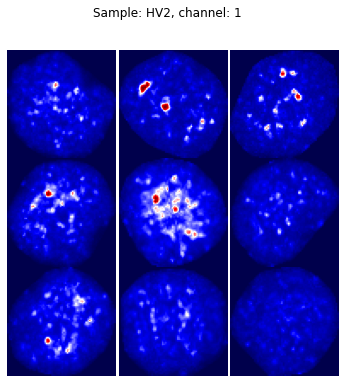

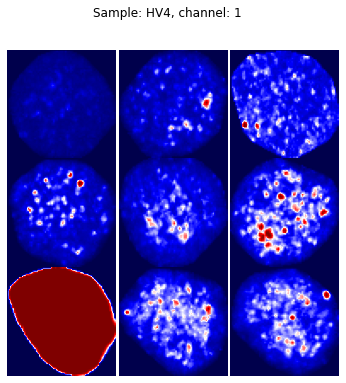

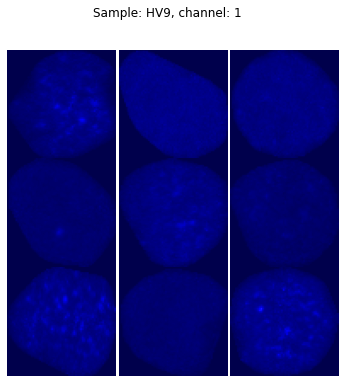

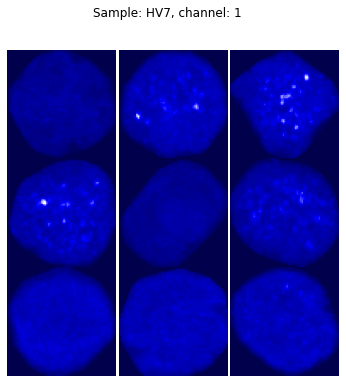

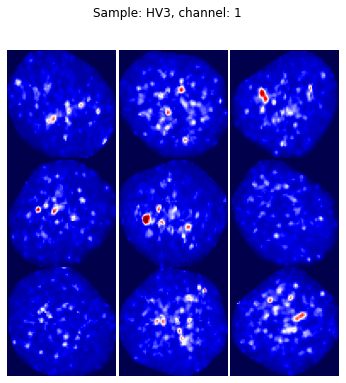

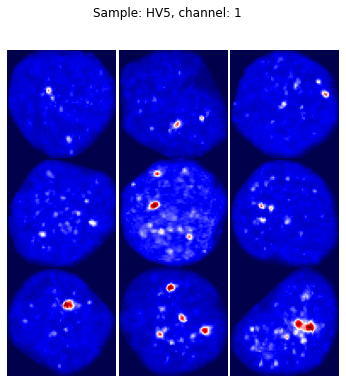

<IPython.core.display.Javascript object>

In [17]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=1, cmap="seismic")

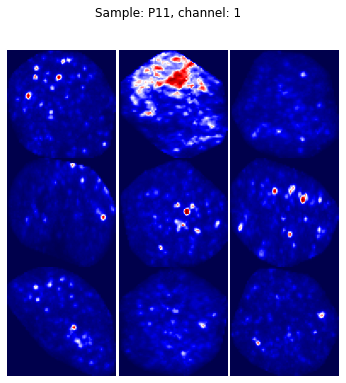

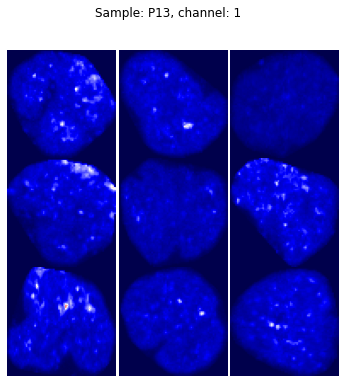

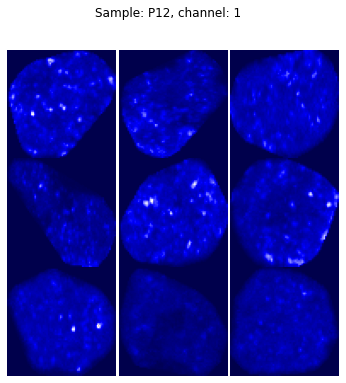

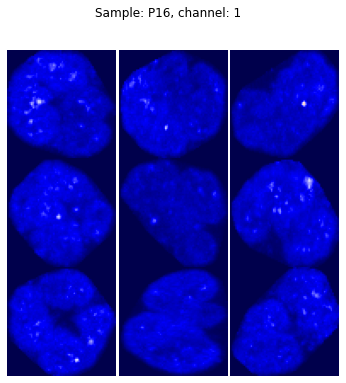

<IPython.core.display.Javascript object>

In [18]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=1, cmap="seismic")

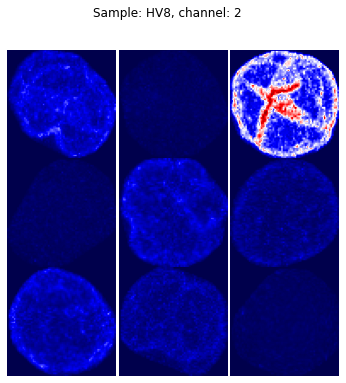

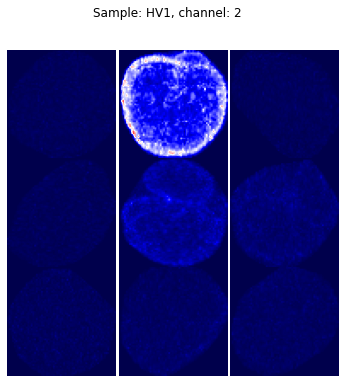

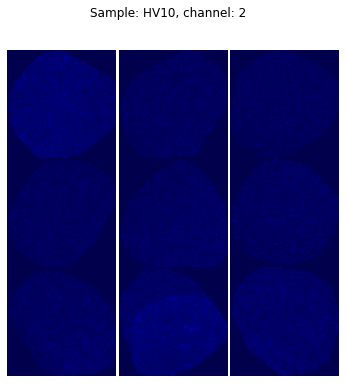

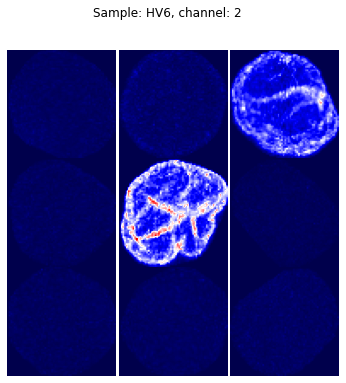

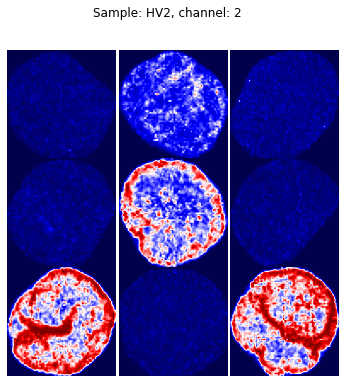

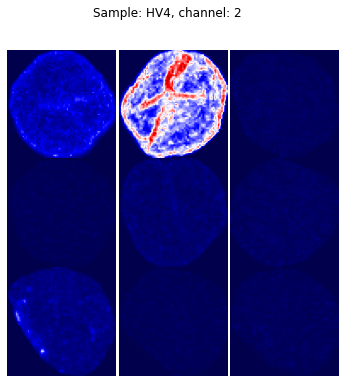

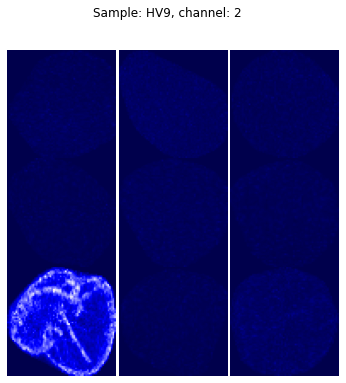

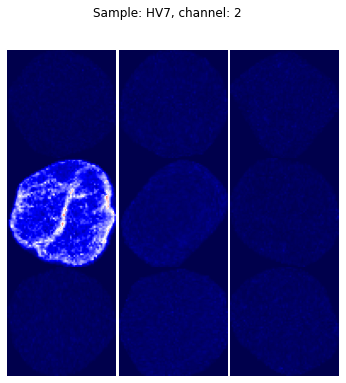

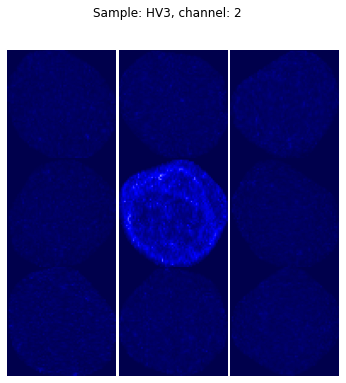

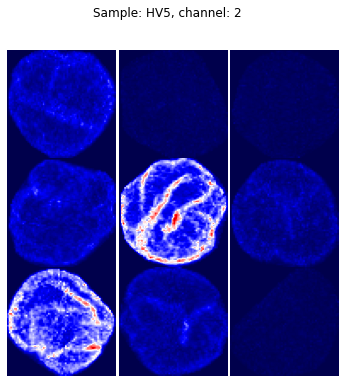

<IPython.core.display.Javascript object>

In [19]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=2, cmap="seismic")

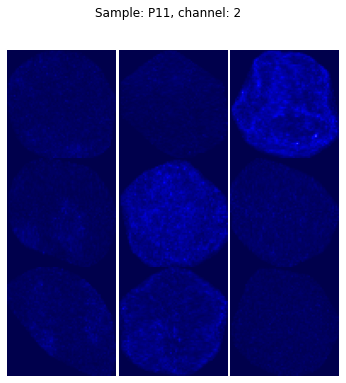

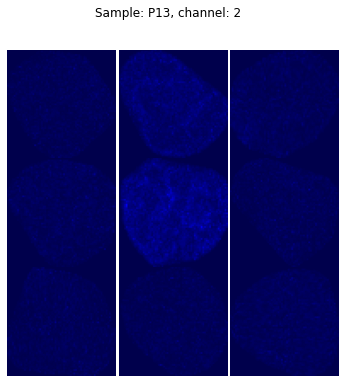

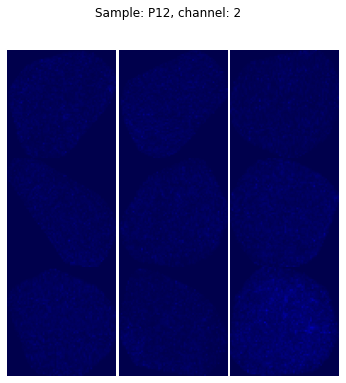

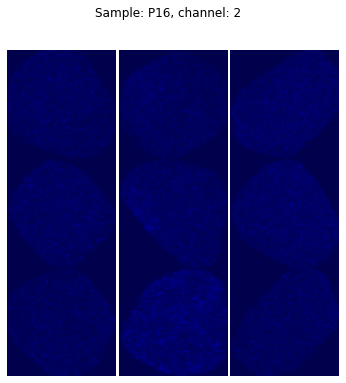

<IPython.core.display.Javascript object>

In [20]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=2, cmap="seismic")

The plotted nuclei illustrate the great inter- and intra-sample variability of the chromatin organization and the protein levels in human PBMCs even in healthy patients. In the following we will have a closer look at this heterogneity.

---

## 3. Preprocessing

From now on we will focus on the extracted feature sets for our analyses. To this end, we will first run a basic preprocessing pipeline that
1. Removes nuclei that did not pass the quality checks as flagged by the qc_pass attribute in the data
2. Remove any constant features and nuclei with missing values
3. Remove features correlated with a Pearson correlation of larger than 0.8
4. Normalize the data to unit variance and zero-mean.

In [21]:
filtered_data = nuclear_features.loc[nuclear_features["qc_pass"] == True]
print(
    "Nuclei that did not pass the quality check: {}/{}. Remaining: {}.".format(
        len(nuclear_features) - len(filtered_data),
        len(nuclear_features),
        len(filtered_data),
    )
)

Nuclei that did not pass the quality check: 219/3731. Remaining: 3512.


<IPython.core.display.Javascript object>

In [22]:
data = filtered_data.loc[:, (filtered_data != filtered_data.iloc[0]).any()]
data = data.loc[:, ~data.columns.str.startswith("normalized")]
data = data.dropna(axis=1)
print(
    "Removed {} constant or features with missing values. Remaining: {}.".format(
        len(filtered_data.columns) - len(data.columns), len(data.columns)
    )
)

Removed 50 constant or features with missing values. Remaining: 263.


<IPython.core.display.Javascript object>

In [23]:
n_nuclei = len(data)
data = data.dropna()
print(
    "Removed {}/{} nuclei with missing values. Remaining: {}".format(
        n_nuclei - len(data), n_nuclei, len(data)
    )
)

Removed 0/3512 nuclei with missing values. Remaining: 3512


<IPython.core.display.Javascript object>

In [24]:
# Deselect label and sample column and remove some other unimportant features
numeric_data = data.iloc[:, 1:-2].drop(
    [
        "centroid-0",
        "centroid-1",
        "orientation",
        "weighted_centroid-0",
        "weighted_centroid-1",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [25]:
# Maintain features that have at most a Pearson correlation of 0.8
threshold = 0.8

# Control data
data_corr = numeric_data.corr().abs()
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(
    "Removed {}/{} features with a Pearson correlation above {}. Remaining: {}".format(
        len(to_drop),
        len(numeric_data.columns),
        threshold,
        len(numeric_data.columns) - len(to_drop),
    )
)
numeric_data = numeric_data.drop(to_drop, axis=1)

Removed 198/255 features with a Pearson correlation above 0.8. Remaining: 57


<IPython.core.display.Javascript object>

In [26]:
num_data_sc = pd.DataFrame(
    StandardScaler().fit_transform(numeric_data),
    index=numeric_data.index,
    columns=numeric_data.columns,
)
num_data_sc.describe()

min_calliper  max_calliper  smallest_largest_calliper    min_radius  \
count  3.512000e+03   3512.000000               3.512000e+03  3.512000e+03   
mean   4.208226e-16      0.000000               3.075242e-16 -9.711290e-16   
std    1.000142e+00      1.000142               1.000142e+00  1.000142e+00   
min   -3.880548e+00     -2.060200              -4.487553e+00 -5.137635e+00   
25%   -7.306266e-01     -0.731114              -5.769905e-01 -4.396850e-01   
50%   -3.064416e-02     -0.247810               1.619252e-01  1.644457e-01   
75%    6.693383e-01      0.477146               7.454234e-01  6.708451e-01   
max    2.944281e+00      6.518443               1.966158e+00  2.207850e+00   

         med_radius   area_bbarea  std_curvature  npolarity_changes  \
count  3.512000e+03  3.512000e+03   3.512000e+03       3.512000e+03   
mean   1.618548e-15 -2.136484e-15  -3.237097e-16       3.237097e-17   
std    1.000142e+00  1.000142e+00   1.000142e+00       1.000142e+00   
min   -2.920986e+00 -6.276584e+00  -2.393072e+00      -2.398565e+00   
25%   -7.061559e-01 -5.375200e-01  -7.605718e-01      -6.244342e-01   
50%   -1.199330e-01  1.288380e-01  -7.317757e-02      -1.575576e-01   
75%    5.924614e-01  6.823859e-01   7.135491e-01       4.960697e-01   
max    3.516175e+00  2.404967e+00   5.951467e+00       8.806474e+00   

       max_posi_curv  num_prominant_pos_curv  ...  rel_gh2ax_2d_int  \
count   3.512000e+03            3.512000e+03  ...      3.512000e+03   
mean    3.398952e-16           -1.294839e-16  ...     -1.942258e-16   
std     1.000142e+00            1.000142e+00  ...      1.000142e+00   
min    -1.621218e+00           -3.148493e+00  ...     -1.861689e+00   
25%    -6.196807e-01           -6.416901e-01  ...     -7.037523e-01   
50%    -2.375936e-01           -1.403296e-01  ...     -1.097153e-01   
75%     3.181106e-01            8.623915e-01  ...      5.459027e-01   
max     9.042552e+00            3.369194e+00  ...      5.782260e+00   

       min_gh2ax_2d_int  kurtosis_gh2ax_2d_int  skewness_gh2ax_2d_int  \
count      3.512000e+03           3.512000e+03           3.512000e+03   
mean       1.942258e-16          -5.664919e-17          -1.618548e-17   
std        1.000142e+00           1.000142e+00           1.000142e+00   
min       -1.779606e+00          -1.144488e+00          -7.633159e+00   
25%       -6.796834e-01          -5.968971e-01          -4.099949e-01   
50%       -1.310463e-01          -2.900784e-01           1.290906e-01   
75%        5.276815e-01           2.117294e-01           6.221592e-01   
max        1.726887e+01           1.942528e+01           3.776344e+00   

       min_gh2ax_3d_int  kurtosis_gh2ax_3d_int  rel_lamin_2d_int  \
count      3.512000e+03           3.512000e+03      3.512000e+03   
mean       1.294839e-16           5.664919e-17     -1.132984e-16   
std        1.000142e+00           1.000142e+00      1.000142e+00   
min       -1.469423e+00          -7.726396e-01     -6.056135e-01   
25%       -5.878315e-01          -5.590881e-01     -4.565921e-01   
50%       -8.200971e-02          -3.339475e-01     -3.812743e-01   
75%        4.326127e-01           8.973065e-02     -1.157293e-01   
max        3.333995e+01           9.397807e+00      4.981822e+00   

       kurtosis_lamin_2d_int  skewness_lamin_2d_int  kurtosis_lamin_3d_int  
count           3.512000e+03            3512.000000           3.512000e+03  
mean            8.092742e-18               0.000000           1.132984e-16  
std             1.000142e+00               1.000142           1.000142e+00  
min            -1.024297e+00              -7.779498          -1.752870e+00  
25%            -3.836766e-01              -0.380924          -5.346098e-01  
50%            -1.685091e-01               0.092360          -1.594787e-01  
75%             9.273803e-02               0.522279           3.321335e-01  
max             1.211858e+01               3.408500           1.782489e+01  

[8 rows x 57 columns]

<IPython.core.display.Javascript object>

In [27]:
num_data_sc.columns

Index(['min_calliper', 'max_calliper', 'smallest_largest_calliper',
       'min_radius', 'med_radius', 'area_bbarea', 'std_curvature',
       'npolarity_changes', 'max_posi_curv', 'num_prominant_pos_curv',
       'num_prominant_neg_curv', 'frac_peri_w_posi_curvature',
       'frac_peri_w_polarity_changes', 'int_min', 'int_d25', 'int_mode',
       'kurtosis', 'i80_i20', 'nhigh_nlow', 'contrast_100', 'homogeneity_100',
       'correlation_5', 'correlation_25', 'weighted_moments-0-0',
       'weighted_moments_normalized-0-2', 'weighted_moments_normalized-0-3',
       'weighted_moments_normalized-1-1', 'weighted_moments_normalized-1-2',
       'weighted_moments_normalized-2-0', 'weighted_moments_normalized-2-1',
       'weighted_moments_normalized-2-2', 'weighted_moments_normalized-2-3',
       'weighted_moments_normalized-3-0', 'weighted_moments_normalized-3-2',
       'weighted_moments_central-0-1', 'weighted_moments_central-1-0',
       'weighted_moments_central-3-2', 'weighted_moments_

<IPython.core.display.Javascript object>

---

## 4. Overview of the nuclear space.

The tSNE plot below further emphasizes the heterogeneity in the nuclear population. Interestingly, however we can see some indication for a preferential grouping of the nuclei of the healthy volunteer 1,9 and 10 in contrast to the remaining samples.

In [28]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(num_data_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=num_data_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "condition"] = np.array(data.loc[tsne_embs.index, "condition"])

<IPython.core.display.Javascript object>

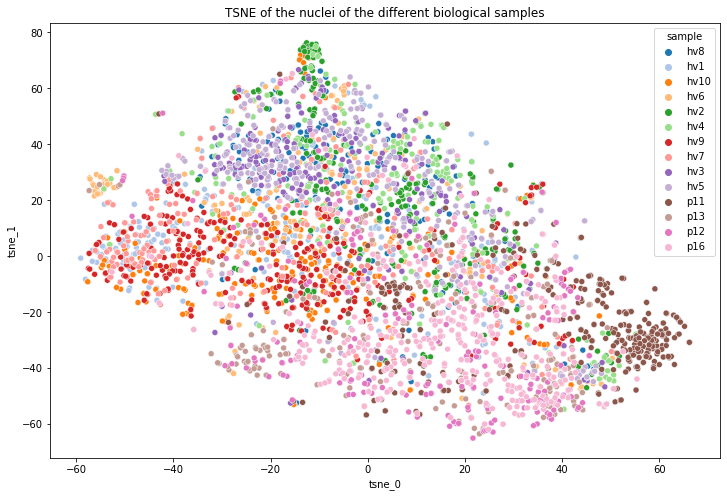

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(figsize=[12, 8])
sns.scatterplot(
    data=tsne_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax, palette="tab20"
)
plt.title("TSNE of the nuclei of the different biological samples")
plt.show()

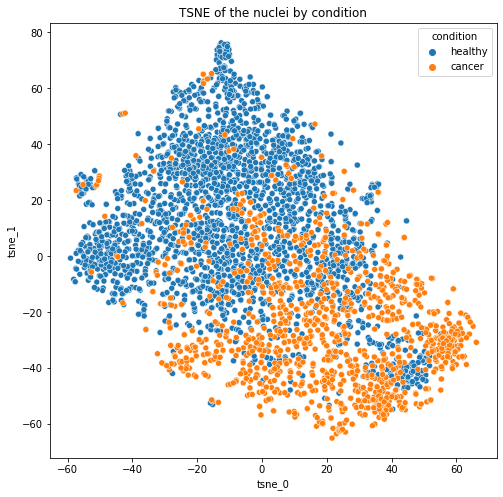

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(figsize=[8, 8])
sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="condition", ax=ax)
plt.title("TSNE of the nuclei by condition")
plt.show()

We see a relative clear separation of the cancer and healthy PBMCs in the tSNE space. However there is a small subpopulation of cells from healthy donors that cluster in the space predominantely occupied by cancer cells.

Let us have a more closer look at those cells, first visually

In [31]:
coi = tsne_embs.loc[
    (tsne_embs["condition"] == "healthy")
    & (tsne_embs["tsne_1"] < -30)
    & (tsne_embs["tsne_0"] > 30),
    :,
]
data.loc[np.random.choice(np.array(coi.index), 9, replace=False), :]

label  min_calliper  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1       2          66.0   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1       2          69.0   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1       2          71.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_2_5        6          66.0   
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_19_2      3          71.0   
HV6_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_40_4       5          64.0   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_8_4        5          54.0   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_6       7          71.0   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_29_3       4          64.0   

                                                   max_calliper  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1           78.0   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1           81.0   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1           79.0   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_2_5            78.0   
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_19_2          80.0   
HV6_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_40_4           79.0   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_8_4            80.0   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_6           89.0   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_29_3           80.0   

                                                   smallest_largest_calliper  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1                    0.846154   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1                    0.851852   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1                    0.898734   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_2_5                     0.846154   
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_19_2                   0.887500   
HV6_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_40_4                    0.810127   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_8_4                     0.675000   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_6                    0.797753   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_29_3                    0.800000   

                                                   min_radius  max_radius  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1    27.053783   39.320627   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1    28.456829   40.827278   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1    25.264757   39.732771   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_2_5     27.952031   40.385117   
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_19_2   29.574700   41.154210   
HV6_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_40_4    24.499773   40.116638   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_8_4     21.146604   41.168316   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_6    24.973755   47.440129   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_29_3    25.729593   40.527748   

                                                   med_radius  avg_radius  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1    34.441545   34.109116   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1    37.052159   36.476973   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1    35.747283   35.697519   
HV8_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_2_5     34.141053   34.102252   
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_19_2   36.835538   36.284113   
HV6_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_40_4    34.432388   34.533376   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_8_4     33.312602   32.835240   
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_6    37.683634   37.132004   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_29_3    36.504248   35.287328   

                                                   mode_radius  d25_radius  \
HV5_PBMC_Dapi_gH2AX__lamin_28_7_21_2X_16bit_40_1     27.053783   32.141233   
HV2_PBMC_Dapi_gH2AX__lamin_11_8_21_2X_16bit_31_1     28.456829   34.797016   
HV4_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_16_1     25.264757

<IPython.core.display.Javascript object>

In [32]:
from collections import Counter

Counter(data["condition"])

Counter({'healthy': 2346, 'cancer': 1166})

<IPython.core.display.Javascript object>

In [33]:
mapper = umap.UMAP().fit(num_data_sc)

<IPython.core.display.Javascript object>

<AxesSubplot:>

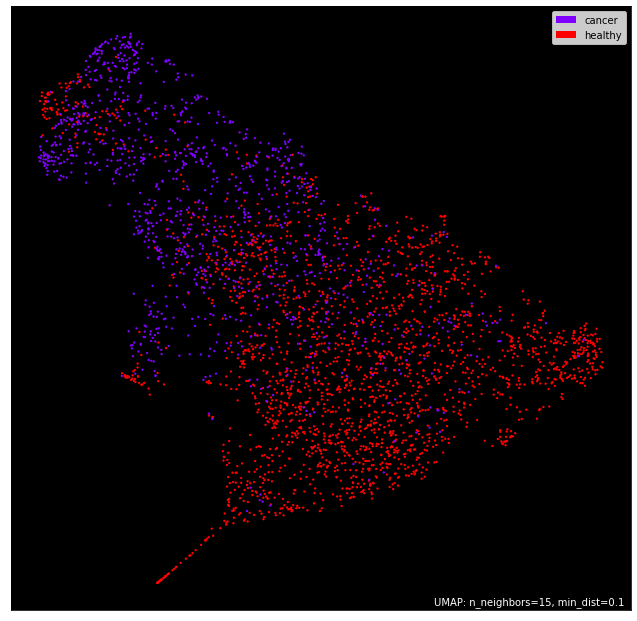

<IPython.core.display.Javascript object>

In [34]:
umap.plot.points(mapper, labels=data.condition, theme="fire")

To confirm that there are no batch effects, we will perform a 10-fold stratified CV procedure for training a RandomForest classifier on the nuclei dataset to distinguish between the different biological samples.

In [35]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(10)
features = np.array(num_data_sc)
# labels = LabelEncoder(np.array(data.loc[]))
labels = np.array(data.loc[:, "condition"])

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

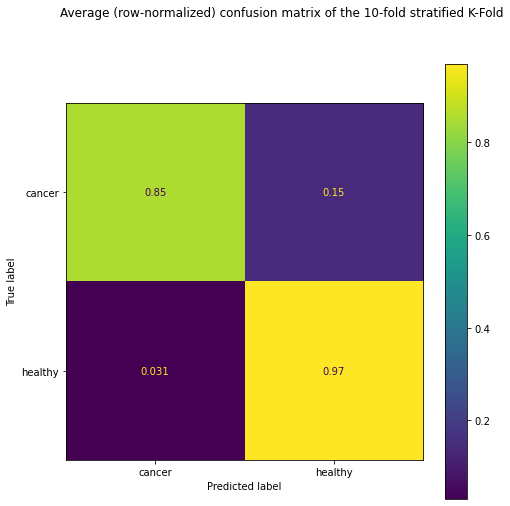

<IPython.core.display.Javascript object>

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["cancer", "healthy"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

The above figure shows the average confusion matrix for a 10-fold stratified cross-validation approach with the rows normalized to sum to 1. We see that thus on average roughly 0.85% of the cancer nuclei get correctly classified, 0.97 of the healthy nuclei. This is expected as not all blood cells will experience the cancer signal and hence undergo stimuli-induced cell-state transitions.

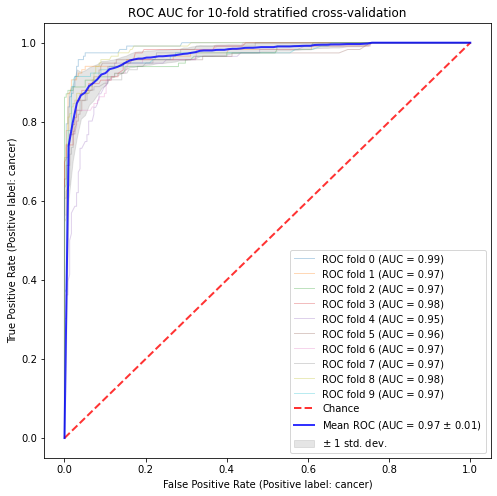

<IPython.core.display.Javascript object>

In [37]:
plot_roc_for_stratified_cv(
    features,
    labels,
    10,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label="cancer",
)
plt.show()

To fully evaluate the performance of the classifier we also compute the AUC under the ROC curve for a 10-fold stratified cross-validation setting which emphasizes the discriminability between the PBMCs from healthy compared to those from cancer patients.

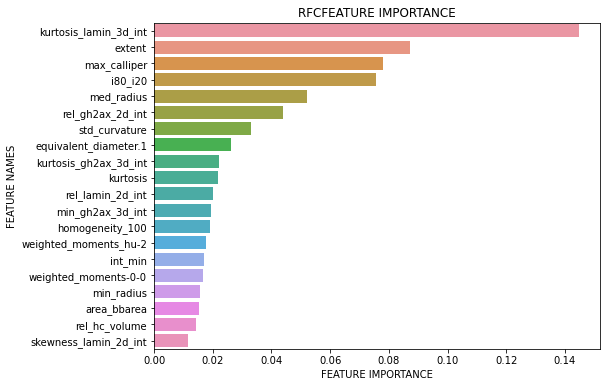

<IPython.core.display.Javascript object>

In [38]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, num_data_sc.columns, "RFC")

When looking at the most discriminative features, we find that a mixture of intensity features mostly with respect to the protein channels as well as shape features describing predominatnly the size and curvature are among the most descriminative among these are the shape of the lamin intensity in 3D and 2D, the moments of the gH2AX intensities, the changes of curvature, circularity and size of the nucleus

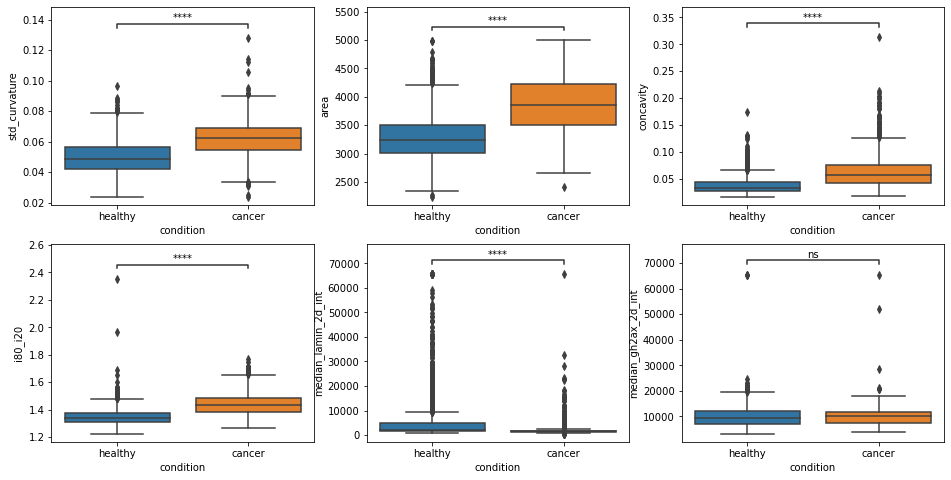

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[16, 8])
ax = ax.flatten()
ax[0] = sns.boxplot(data=data, x="condition", y="std_curvature", ax=ax[0])
add_stat_annotation(
    ax[0],
    data=data,
    x="condition",
    y="std_curvature",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)

ax[1] = sns.boxplot(data=data, x="condition", y="area", ax=ax[1])
add_stat_annotation(
    ax[1],
    data=data,
    x="condition",
    y="area",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)

ax[2] = sns.boxplot(data=data, x="condition", y="concavity", ax=ax[2])
add_stat_annotation(
    ax[2],
    data=data,
    x="condition",
    y="concavity",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)

ax[3] = sns.boxplot(data=data, x="condition", y="i80_i20", ax=ax[3])
add_stat_annotation(
    ax[3],
    data=data,
    x="condition",
    y="i80_i20",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)

ax[4] = sns.boxplot(data=data, x="condition", y="median_lamin_3d_int", ax=ax[4])
add_stat_annotation(
    ax[4],
    data=data,
    x="condition",
    y="median_lamin_3d_int",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[4].set_ylabel("median_lamin_2d_int")

ax[5] = sns.boxplot(data=data, x="condition", y="median_gh2ax_3d_int", ax=ax[5])
add_stat_annotation(
    ax[5],
    data=data,
    x="condition",
    y="median_gh2ax_3d_int",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[5].set_ylabel("median_gh2ax_2d_int")

plt.show()

In [53]:
np.mean(list(Counter(data.loc[:, "sample"]).values())[-4:])

291.5

<IPython.core.display.Javascript object>